In [0]:
#importing packages
import pandas as pd
import numpy as np
import datetime
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


import xgboost as xgb
#from sklearn.linear_model import LinearRegression
#from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import seaborn as sns
from sklearn import preprocessing
from tqdm import tqdm_notebook
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error#model evaluation
#from pylab import rcParams#for ts decomposition
#import statsmodels.api as sm
#from pandas.plotting import autocorrelation_plot
#from statsmodels.graphics.gofplots import qqplot

data_path='/content/drive/My Drive/Colab Notebooks/data/'

#downcasting dataframe
def downcast_dtypes(df):

  # Select columns to downcast
  float_cols = [c for c in df if df[c].dtype == "float64"]
  int_cols =   [c for c in df if df[c].dtype == "int64"]

  # Downcast
  df[float_cols] = df[float_cols].astype(np.float32)
  df[int_cols]   = df[int_cols].astype(np.int32)

  return df

save_list = dir()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Import

In [0]:
items=pd.read_csv(data_path+'items.csv')
items_cat=pd.read_csv(data_path+'item_categories.csv')
sales_train=pd.read_csv(data_path+'sales_train.csv')
shops=pd.read_csv(data_path+'shops.csv')
sales_test=pd.read_csv(data_path+'test.csv')

We have no missing nor nan values on the train set and the types of float and ints could be changed if needed to 32 bits versions.


In [0]:
print('are all item ids in train set present in items list? ', all(el1 in sales_train.item_id for el1 in items.item_id))
print('are all shops ids in train set present in shops list? ',all(el1 in sales_train.shop_id for el1 in shops.shop_id))
print('are all item ids in test set present in item list? ',all(el1 in sales_test.item_id for el1 in items.item_id))
print('are all shops ids in test set present in shops list? ',all(el1 in sales_test.shop_id for el1 in shops.shop_id))
print('are all item ids in test set present in item list? ',all(el1 in sales_test.item_id for el1 in items.item_id))
print('are all shops ids in test set present in shops list? ',all(el1 in sales_test.shop_id for el1 in shops.shop_id))

are all item ids in train set present in items list?  True
are all shops ids in train set present in shops list?  True
are all item ids in test set present in item list?  True
are all shops ids in test set present in shops list?  True
are all item ids in test set present in item list?  True
are all shops ids in test set present in shops list?  True


In [0]:
print('do we have record on every item of the test set in the train set? ',all(el1 in sales_test.item_id for el1 in sales_train.item_id))

do we have record on every item of the test set in the train set?  True


# Data Preprocessing 

## Combining train and test setsmm

In [0]:
sales_train.drop('date',axis=1,inplace=True)
sales_test.drop('ID',axis=1,inplace=True)

In [0]:
sales_test['item_cnt_day'],sales_test['date_block_num']=0,34
all_data=pd.concat([sales_train,sales_test],sort=False)

## Creating grid of objects


In [0]:
index_cols = ['shop_id','item_id','date_block_num']

grid = [] 


for block_num in tqdm_notebook(all_data['date_block_num'].unique()):
  l_items = all_data.loc[all_data.date_block_num==block_num,'item_id'].unique()
  l_shops = all_data.loc[all_data.date_block_num==block_num,'shop_id'].unique()
  grid.append(np.array(list(product(*[l_shops,l_items,[block_num]])),dtype="int32"))
    
#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols)
grid=grid.sort_values(index_cols, ascending=[True, True,True])

In [0]:
len(grid)

11128050

# EDA (dont run this-didnt check if this still runs)

## Aggegations for EDA

In [0]:
index_cols = ['date_block_num','item_id', 'shop_id']
all_data.item_cnt_day=np.clip(all_data.item_cnt_day,0,20)
all_data_monthly=all_data.groupby(index_cols,as_index=False).agg({'item_price':['sum'],'item_cnt_day':['sum']})
all_data_monthly.columns = [col[0] if col[-1]=='' else col[0]+'_'+col[-1] for col in all_data_monthly.columns.values]
all_data_monthly.rename(columns = {'item_cnt_day_sum':'item_cnt_month'}, inplace = True)
all_data_monthly.rename(columns = {'item_price_sum':'item_price_month'}, inplace = True)
all_data_monthly=all_data_monthly.merge(items.drop('item_name',axis=1),on='item_id').merge(shops,on='shop_id').merge(items_cat,on='item_category_id')
#getting city names
all_data_monthly['city']=all_data_monthly['shop_name'].map(lambda row:row.split(" ")[0])
#getting category and sub category names
all_data_monthly['category']=all_data_monthly['item_category_name'].map(lambda row:row.split("-")[0])
all_data_monthly['sub-category']=all_data_monthly['item_category_name'].map(lambda row:row.split("-")[1] if len(row.split("-"))==2 else "no sub-category")

all_data_monthly=all_data_monthly[all_data_monthly.date_block_num!=34]
#adding date features 
all_data_monthly['month']=all_data_monthly['date_block_num']%12
all_data_monthly['year']=all_data_monthly['date_block_num']//12
all_data_monthly['quarter']=(all_data_monthly['date_block_num']%12)//3

#display(all_data_monthly.head(3))
#monthly aggregation
monthly_agg=all_data_monthly.groupby('month',as_index=False).agg({'item_price_month':['mean','sum'],'item_cnt_month':['mean','sum']})
monthly_agg.columns = [col[0] if col[-1]=='' else col[0]+'_month_'+col[-1] for col in monthly_agg.columns.values]
#monthly aggregation
yearly_agg=all_data_monthly.groupby('year',as_index=False).agg({'item_price_month':['mean','sum'],'item_cnt_month':['mean','sum']})
yearly_agg.columns = [col[0] if col[-1]=='' else col[0]+'_month_'+col[-1] for col in yearly_agg.columns.values]
#quarter aggregate
quarter_agg=all_data_monthly.groupby('quarter',as_index=False).agg({'item_price_month':['mean','sum'],'item_cnt_month':['mean','sum','count']})
quarter_agg.columns = [col[0] if col[-1]=='' else col[0]+'_month_'+col[-1] for col in quarter_agg.columns.values]
#shop wise aggregation
shop_agg=all_data_monthly.groupby('shop_name',as_index=False).agg({'item_price_month':['mean','sum'],'item_cnt_month':['mean','sum']})
shop_agg.columns = [col[0] if col[-1]=='' else col[0]+'_month_'+col[-1] for col in shop_agg.columns.values]
#item wise aggregation
item_agg=all_data_monthly.groupby('item_id',as_index=False).agg({'item_price_month':['mean','sum'],'item_cnt_month':['mean','sum']})
item_agg.columns = [col[0] if col[-1]=='' else col[0]+'_month_'+col[-1] for col in item_agg.columns.values]
#category wise aggregation
cat_agg=all_data_monthly.groupby('category',as_index=False).agg({'item_price_month':['mean','sum'],'item_cnt_month':['mean','sum']})
cat_agg.columns = [col[0] if col[-1]=='' else col[0]+'_month_'+col[-1] for col in cat_agg.columns.values]
#cat_agg.item_category_id=cat_agg.item_category_id.astype('int32')
#sub-category wise aggregation
subcat_agg=all_data_monthly.groupby('sub-category',as_index=False).agg({'item_price_month':['mean','sum'],'item_cnt_month':['mean','sum']})
subcat_agg.columns = [col[0] if col[-1]=='' else col[0]+'_month_'+col[-1] for col in subcat_agg.columns.values]
#cat_agg.item_category_id=cat_agg.item_category_id.astype('int32')
#train.groupby(index_cols,as_index=False).agg({'item_price':['mean','sum'],'item_cnt_day':['mean','sum']})
del all_data_monthly

## Monthly,yearly and quarter wise sales


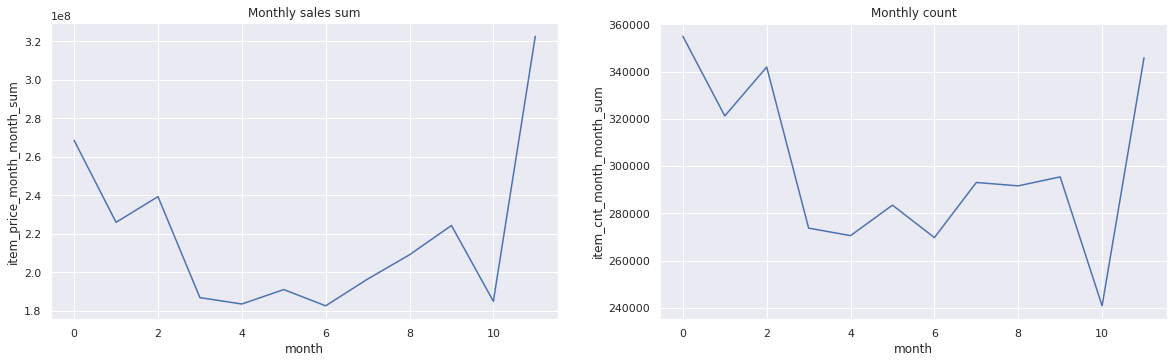

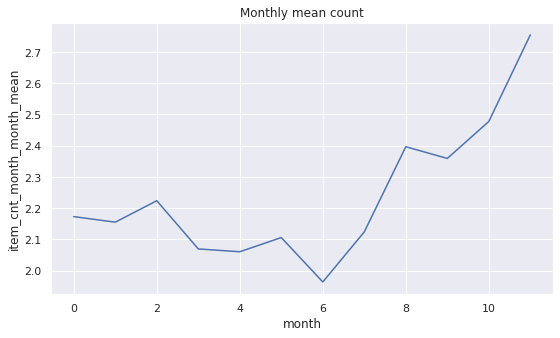

In [0]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.lineplot(x='month',y='item_price_month_month_sum',data=monthly_agg).set_title("Monthly sales sum")
plt.subplot(2,2,2)
sns.lineplot(x='month',y='item_cnt_month_month_sum',data=monthly_agg).set_title("Monthly count")
plt.show()
plt.figure(figsize=(9,5))
sns.lineplot(x='month',y='item_cnt_month_month_mean',data=monthly_agg).set_title("Monthly mean count")
plt.show()

We can notice that both mean and sum of sales increase at the end of the year and peek at december which is expected and then settle down and reach their lowest points in the may-juin-july period.

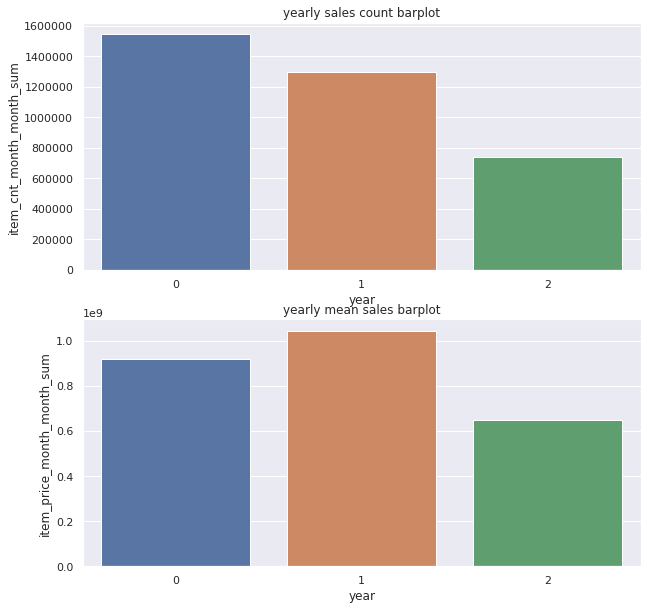

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.barplot(x='year',y='item_cnt_month_month_sum',data=yearly_agg).set_title("yearly sales count barplot")
plt.subplot(2,1,2)
sns.barplot(x='year',y='item_price_month_month_sum',data=yearly_agg).set_title("yearly mean sales barplot")
plt.show()

year 3 (green) shows quite less sales than the previous two (which is normal when we have november's and december's sales missing ,especially when december usually reaches the sales peak)

In [0]:
quarter_agg.columns

Index(['quarter', 'item_price_month_month_mean', 'item_price_month_month_sum',
       'item_cnt_month_month_mean', 'item_cnt_month_month_sum',
       'item_cnt_month_month_count'],
      dtype='object')

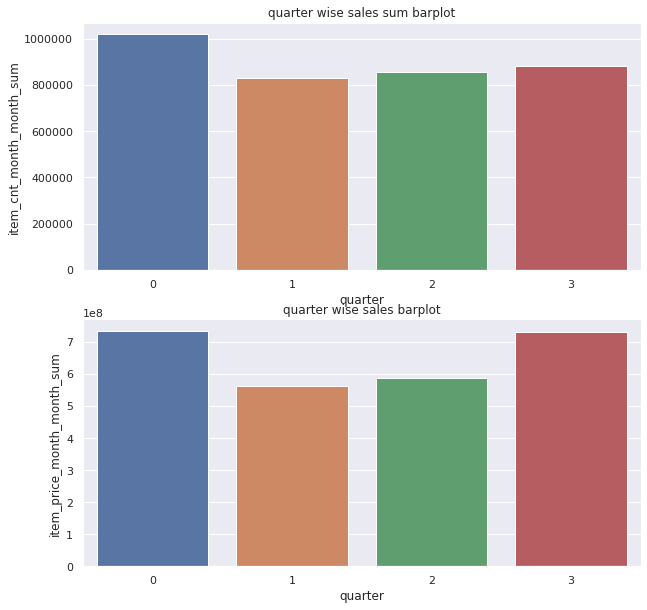

In [0]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.barplot(x='quarter',y='item_cnt_month_month_sum',data=quarter_agg).set_title("quarter wise sales sum barplot")
plt.subplot(2,1,2)
sns.barplot(x='quarter',y='item_price_month_month_sum',data=quarter_agg).set_title("quarter wise sales barplot")
plt.show()

again lets remember that for the 3rd quarter we have 2 last months data of year 3 missing so the values of 3rd quarter should be higher.

## Shops sales

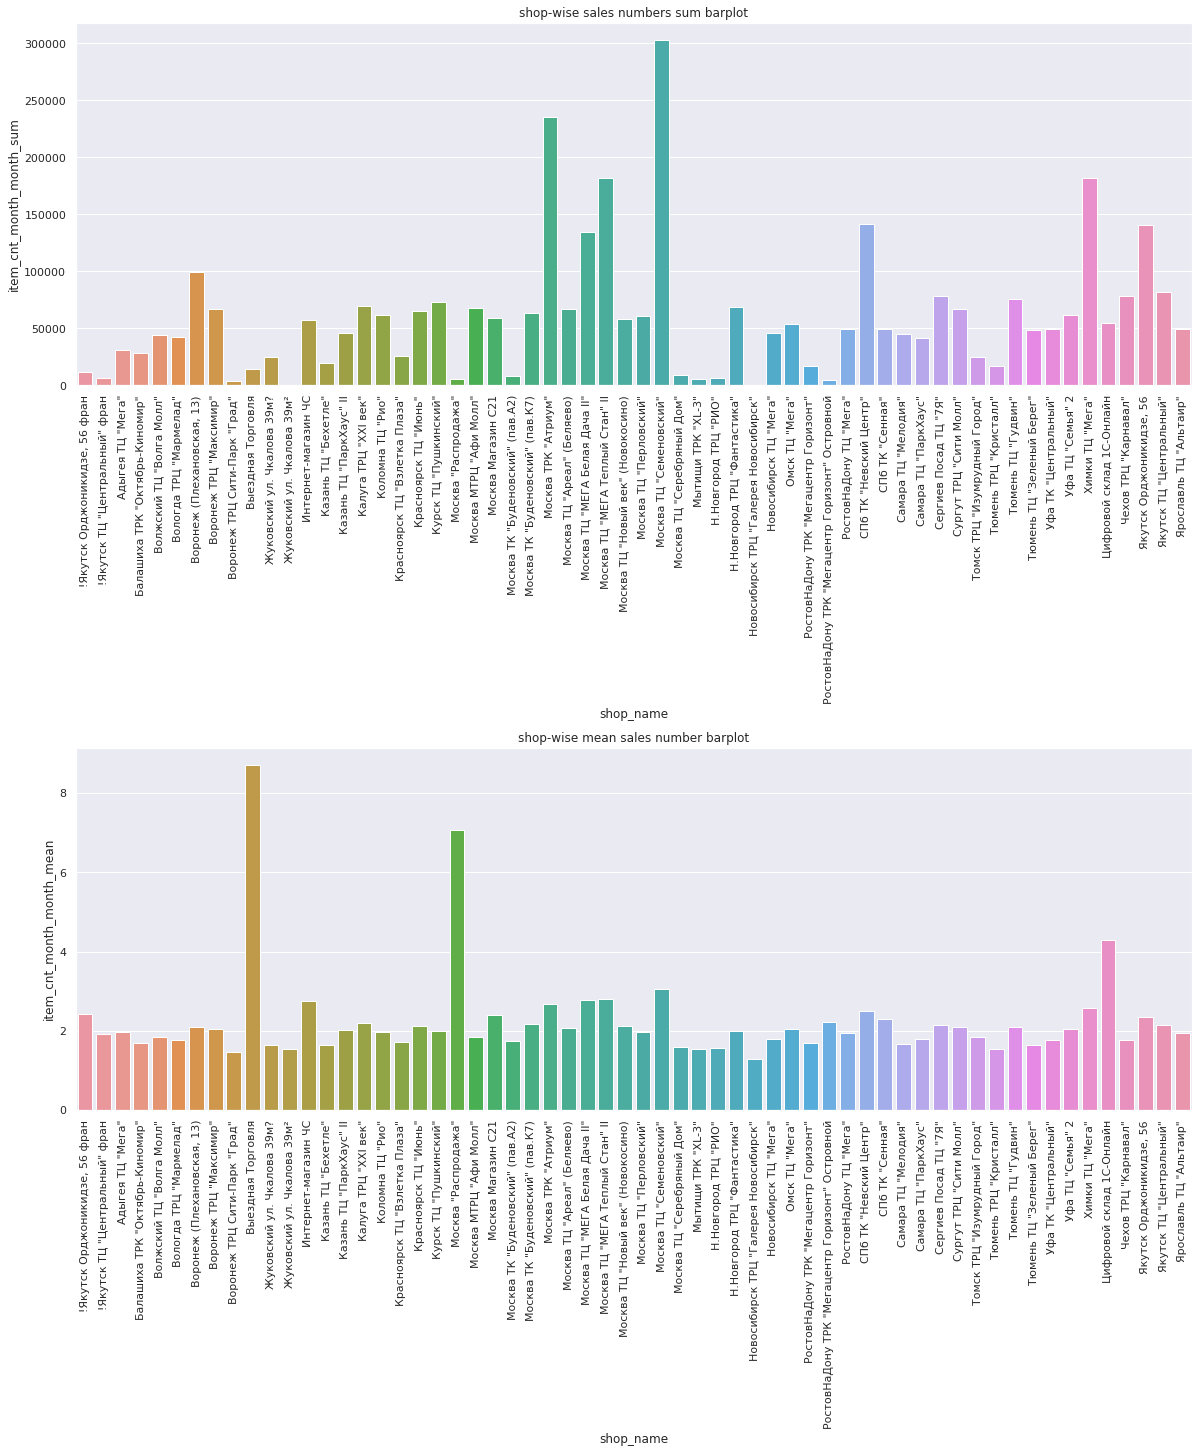

In [0]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace = 1)
plt.subplot(2,1,1)
sns.barplot(x='shop_name',y='item_cnt_month_month_sum',data=shop_agg).set_title("shop-wise sales numbers sum barplot")
plt.xticks(rotation='vertical')
plt.subplot(2,1,2)
sns.barplot(x='shop_name',y='item_cnt_month_month_mean',data=shop_agg).set_title("shop-wise mean sales number barplot")
plt.xticks(rotation='vertical')
plt.show()

More than half the shops have decent number of sales. there are some like 11 and 36 that dont any sales whatsoever.On the other side, shops number 24 and 31 generated more sales than any other shop.


## Items Sales

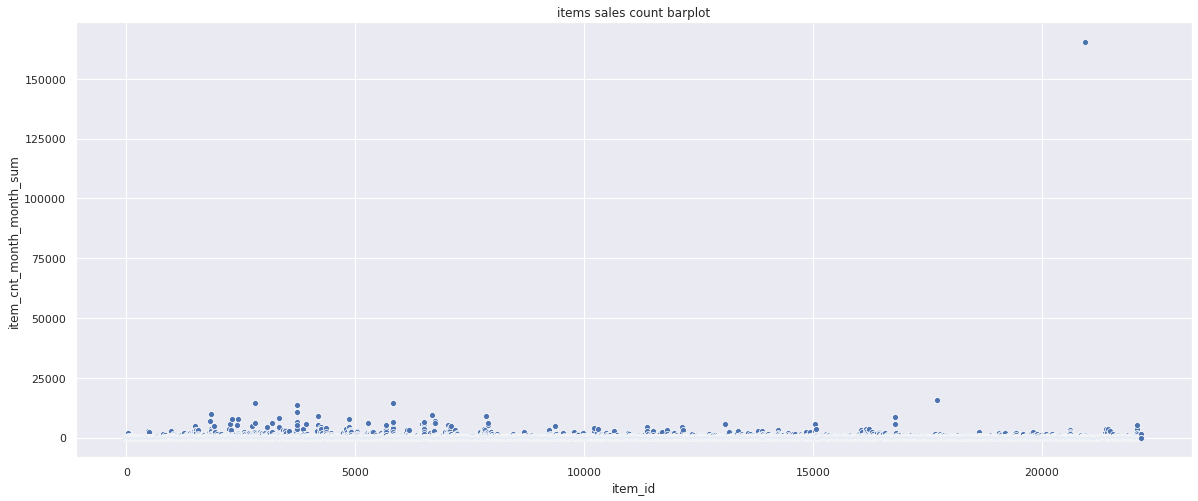

In [0]:
plt.figure(figsize=(20,8))
sns.scatterplot(x='item_id',y='item_cnt_month_month_sum',data=item_agg).set_title("items sales count barplot")
plt.show()

In [0]:
max_item_id=item_agg.loc[item_agg.item_cnt_month_month_sum.idxmax()][0]
print('most sold item : ',items[items.item_id==max_item_id].item_name)

most sold item :  20949    Фирменный пакет майка 1С Интерес белый (34*42)...
Name: item_name, dtype: object


we notice that the item the most sold in quantity were plastic bags. which, we might consider as an outlier.



## Categories sales

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

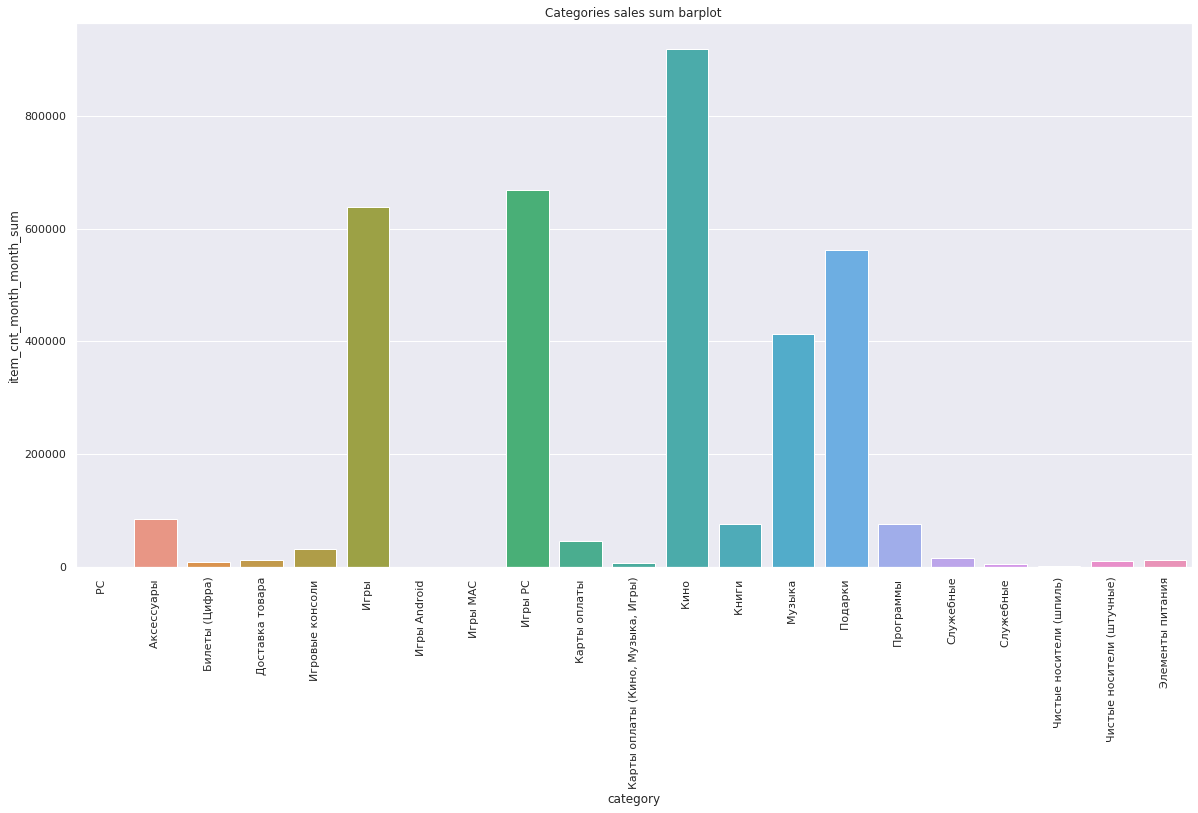

In [0]:
plt.figure(figsize=(20,10))
sns.barplot(x='category',y='item_cnt_month_month_sum',data=cat_agg).set_title("Categories sales sum barplot")
plt.xticks(rotation='vertical')


There are a number of categories that generate quite more money, this is depndendent on the price of each item.

## Sub-Categories sales

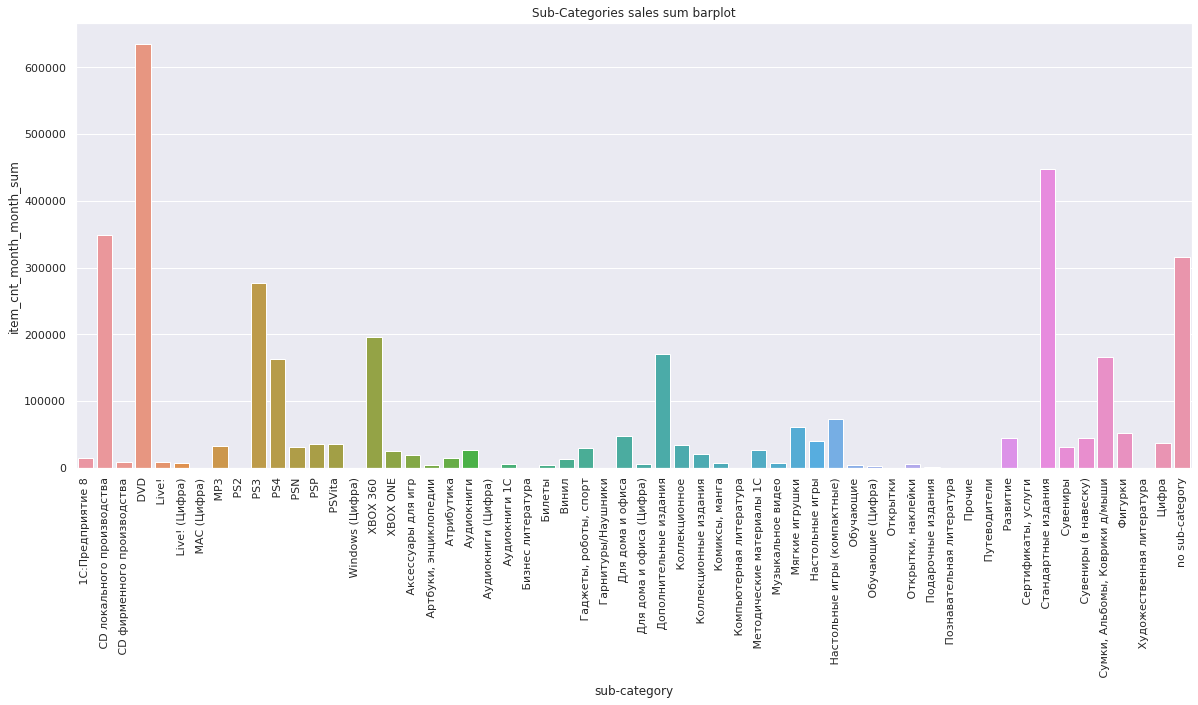

In [0]:
plt.figure(figsize=(20,18))
plt.subplot(2,1,1)
sns.barplot(x='sub-category',y='item_cnt_month_month_sum',data=subcat_agg).set_title("Sub-Categories sales sum barplot")
plt.xticks(rotation='vertical')
plt.show()

In [0]:
del yearly_agg,quarter_agg,shop_agg,cat_agg,subcat_agg

# Feature Engineering

## sum features

In [0]:
# Groupby data to get shop-item-month aggregates 
gb = all_data.groupby(['shop_id', 'item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'item_cnt'},inplace=True)
gb['item_cnt']=np.clip(gb['item_cnt'],0,20)
grid_data = pd.merge(grid, gb, how='left', on=['shop_id', 'item_id', 'date_block_num']).fillna(0)

# Same as above but with shop-month aggregates
gb = all_data.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'item_cnt_shop'},inplace=True)
grid_data = pd.merge(grid_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)


# Same as above but with item-month aggregates
gb = all_data.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns={'item_cnt_day':'item_cnt_item'},inplace=True)
grid_data = pd.merge(grid_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)


## date features

In [0]:
grid_data['month']=grid_data['date_block_num']%12
grid_data['year']=grid_data['date_block_num']//12
grid_data['quarter']=(grid_data['date_block_num']%12)//3

## text features

In [0]:
grid_data=grid_data.merge(items.drop('item_name',axis=1),on='item_id').merge(shops,on='shop_id').merge(items_cat,on='item_category_id')
#getting city names
grid_data['city']=grid_data['shop_name'].map(lambda row:row.split(" ")[0])
#getting category and sub category names
grid_data['category']=grid_data['item_category_name'].map(lambda row:row.split("-")[0])
grid_data['sub-category']=grid_data['item_category_name'].map(lambda row:row.split("-")[1] if len(row.split("-"))==2 else "no sub-category")


In [0]:
grid_data.describe()

,shop_id,item_id,date_block_num,item_cnt,item_cnt_shop,item_cnt_item,month,year,quarter,item_category_id
count,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07
mean,3.119598e+01,1.130368e+04,1.533958e+01,2.930712e-01,2.291776e+03,1.507140e+01,5.268734e+00,8.392370e-01,1.432618e+00,4.494411e+01
std,1.735381e+01,6.210930e+03,9.760396e+00,1.212356e+00,1.902896e+03,8.347950e+01,3.418489e+00,7.874887e-01,1.116002e+00,1.514009e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.600000e+01,5.947000e+03,7.000000e+00,0.000000e+00,1.188000e+03,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,3.700000e+01
50%,3.000000e+01,1.138800e+04,1.500000e+01,0.000000e+00,1.758000e+03,4.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,4.000000e+01
75%,4.700000e+01,1.659200e+04,2.300000e+01,0.000000e+00,2.605000e+03,1.100000e+01,8.000000e+00,1.000000e+00,2.000000e+00,5.500000e+01
max,5.900000e+01,2.216900e+04,3.400000e+01,2.000000e+01,1.560700e+04,9.619000e+03,1.100000e+01,2.000000e+00,3.000000e+00,8.300000e+01


## Lag Feature(s)


In [0]:
'''
save_list.append('train_test')
for name in dir():
    if name not in save_list:
        del globals()[name]
        del locals()[name]
'''

"\nsave_list.append('train_test')\nfor name in dir():\n    if name not in save_list:\n        del globals()[name]\n        del locals()[name]\n"

In [0]:
#Creating lag features
index_cols = ['date_block_num','item_id', 'shop_id']
# List of columns that we will use to create lags
cols_to_rename = ['item_cnt','item_cnt_shop',	'item_cnt_item']

shift_range = [1,2,3,4,5,6,12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = grid_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    grid_data = pd.merge(grid_data, train_shift, on=index_cols, how='left')

del train_shift

#print(grid_data.isnull().sum())
#we wont use 12 first blocks (because of lag)
grid_data=grid_data[grid_data.date_block_num>=12]
#print(grid_data.isnull().sum())
#putting 0 in the cases where we cant find the item in past months
grid_data.fillna(0,inplace=True)
#print(grid_data.isnull().sum())

In [0]:
#grid_data.to_csv(data_path+'grid_data_after_lag.csv',index=False)

In [0]:
#grid_data=pd.read_csv(data_path+'grid_data_after_lag.csv',index_col=None)
#grid_data=downcast_dtypes(grid_data)

## Rolling Window(takes time) (and was not used)

In [0]:
index_cols = ['date_block_num','item_id', 'shop_id']
grid_data=grid_data.sort_values(index_cols, ascending=[True, True,True])
grid_data.head()

,shop_id,item_id,date_block_num,item_cnt,item_cnt_shop,item_cnt_item,month,year,quarter,item_category_id,shop_name,item_category_name,city,category,sub-category,item_cnt_lag_1,item_cnt_shop_lag_1,item_cnt_item_lag_1,item_cnt_lag_2,item_cnt_shop_lag_2,item_cnt_item_lag_2,item_cnt_lag_3,item_cnt_shop_lag_3,item_cnt_item_lag_3,item_cnt_lag_4,item_cnt_shop_lag_4,item_cnt_item_lag_4,item_cnt_lag_5,item_cnt_shop_lag_5,item_cnt_item_lag_5,item_cnt_lag_6,item_cnt_shop_lag_6,item_cnt_item_lag_6,item_cnt_lag_12,item_cnt_shop_lag_12,item_cnt_item_lag_12
4112869,2,27,12,0.0,895.0,1.0,0,1,0,19,"Адыгея ТЦ ""Мега""",Игры - PS3,Адыгея,Игры,PS3,0.0,1326.0,4.0,0.0,853.0,2.0,0.0,793.0,6.0,0.0,949.0,1.0,0.0,878.0,1.0,0.0,809.0,3.0,1.0,1151.0,7.0
4120222,3,27,12,0.0,971.0,1.0,0,1,0,19,"Балашиха ТРК ""Октябрь-Киномир""",Игры - PS3,Балашиха,Игры,PS3,1.0,1138.0,4.0,0.0,973.0,2.0,0.0,798.0,6.0,0.0,1021.0,1.0,0.0,891.0,1.0,0.0,729.0,3.0,0.0,767.0,7.0
4127575,4,27,12,0.0,1437.0,1.0,0,1,0,19,"Волжский ТЦ ""Волга Молл""",Игры - PS3,Волжский,Игры,PS3,0.0,2253.0,4.0,0.0,1487.0,2.0,0.0,1462.0,6.0,0.0,1518.0,1.0,0.0,1718.0,1.0,0.0,1384.0,3.0,0.0,2117.0,7.0
4134927,5,27,12,0.0,1642.0,1.0,0,1,0,19,"Вологда ТРЦ ""Мармелад""",Игры - PS3,Вологда,Игры,PS3,0.0,2224.0,4.0,0.0,1392.0,2.0,0.0,1269.0,6.0,0.0,1291.0,1.0,1.0,1514.0,1.0,0.0,1269.0,3.0,0.0,0.0,0.0
4142046,6,27,12,0.0,3046.0,1.0,0,1,0,19,"Воронеж (Плехановская, 13)",Игры - PS3,Воронеж,Игры,PS3,0.0,5482.0,4.0,0.0,3824.0,2.0,0.0,3549.0,6.0,0.0,3986.0,1.0,0.0,3709.0,1.0,0.0,3368.0,3.0,0.0,3699.0,7.0


In [0]:
#This takes time
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in tqdm_notebook(range(len(function_list))):
  grid_data[('item_cnt_'+function_name[i])] = grid_data.groupby(['shop_id','item_id'])['item_cnt']\
  .apply(function_list[i])

# Drop na (replace the std feature nan values)
grid_data.fillna(0,inplace=True)

In [0]:
grid_data.to_csv(data_path+'grid_data_after_rolling_Final.csv',index=False)
#grid_data.to_csv(data_path+'grid_data_after_rolling2_clip.csv',index=False)

In [0]:
grid_data.head()

,shop_id,item_id,date_block_num,item_cnt,item_cnt_shop,item_cnt_item,month,year,quarter,item_category_id,shop_name,item_category_name,city,category,sub-category,item_cnt_lag_1,item_cnt_shop_lag_1,item_cnt_item_lag_1,item_cnt_lag_2,item_cnt_shop_lag_2,item_cnt_item_lag_2,item_cnt_lag_3,item_cnt_shop_lag_3,item_cnt_item_lag_3,item_cnt_lag_4,item_cnt_shop_lag_4,item_cnt_item_lag_4,item_cnt_lag_5,item_cnt_shop_lag_5,item_cnt_item_lag_5,item_cnt_lag_6,item_cnt_shop_lag_6,item_cnt_item_lag_6,item_cnt_lag_12,item_cnt_shop_lag_12,item_cnt_item_lag_12,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
4112869,2,27,12,0.0,895.0,1.0,0,1,0,19,"Адыгея ТЦ ""Мега""",Игры - PS3,Адыгея,Игры,PS3,0.0,1326.0,4.0,0.0,853.0,2.0,0.0,793.0,6.0,0.0,949.0,1.0,0.0,878.0,1.0,0.0,809.0,3.0,1.0,1151.0,7.0,0.0,0.0,0.0,0.0
4120222,3,27,12,0.0,971.0,1.0,0,1,0,19,"Балашиха ТРК ""Октябрь-Киномир""",Игры - PS3,Балашиха,Игры,PS3,1.0,1138.0,4.0,0.0,973.0,2.0,0.0,798.0,6.0,0.0,1021.0,1.0,0.0,891.0,1.0,0.0,729.0,3.0,0.0,767.0,7.0,0.0,0.0,0.0,0.0
4127575,4,27,12,0.0,1437.0,1.0,0,1,0,19,"Волжский ТЦ ""Волга Молл""",Игры - PS3,Волжский,Игры,PS3,0.0,2253.0,4.0,0.0,1487.0,2.0,0.0,1462.0,6.0,0.0,1518.0,1.0,0.0,1718.0,1.0,0.0,1384.0,3.0,0.0,2117.0,7.0,0.0,0.0,0.0,0.0
4134927,5,27,12,0.0,1642.0,1.0,0,1,0,19,"Вологда ТРЦ ""Мармелад""",Игры - PS3,Вологда,Игры,PS3,0.0,2224.0,4.0,0.0,1392.0,2.0,0.0,1269.0,6.0,0.0,1291.0,1.0,1.0,1514.0,1.0,0.0,1269.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4142046,6,27,12,0.0,3046.0,1.0,0,1,0,19,"Воронеж (Плехановская, 13)",Игры - PS3,Воронеж,Игры,PS3,0.0,5482.0,4.0,0.0,3824.0,2.0,0.0,3549.0,6.0,0.0,3986.0,1.0,0.0,3709.0,1.0,0.0,3368.0,3.0,0.0,3699.0,7.0,0.0,0.0,0.0,0.0


# Modeling

In [0]:
#all_data2=pd.read_csv(data_path+'grid_data_after_rolling_Final.csv',index_col=None)

In [0]:
all_data=grid_data
all_data=downcast_dtypes(all_data)
#Label encoding categroical features
categorical_features =all_data.select_dtypes("object").columns
le = preprocessing.LabelEncoder()
for i in categorical_features:
  le.fit(all_data[str(i)].unique())
  all_data[str(i)]=le.transform(all_data[str(i)])
all_data.sample(2)

all_data=downcast_dtypes(all_data)

In [0]:
from catboost import CatBoostRegressor

categorical_features =list(range(9))
catboost_model = CatBoostRegressor(
    iterations=250,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=,
    loss_function='RMSE',

)

catboost_model.fit(
    X_train, y_train,
    cat_features=categorical_features,
    eval_set=(X_test, y_test),
    plot=True
)

## Tuning

In [0]:
dates = all_data['date_block_num']
#to_drop_cols=['item_cnt_shop', 'item_cnt_item', 'item_cnt', 'date_block_num','item_category_name','shop_name','month','quarter',	'city',	'category',	'sub-category']
to_drop_cols=['item_cnt_shop', 'item_cnt_item', 'item_cnt', 'date_block_num','item_category_name','shop_name','quarter',	'category',	'sub-category','item_cnt_min',	'item_cnt_max',	'item_cnt_mean',	'item_cnt_std','year']
test_block=33
dates_train = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

X_train= all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
print(X_train.columns)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train= all_data.loc[dates <  test_block, 'item_cnt'].values
y_test = all_data.loc[dates ==  test_block, 'item_cnt'].values


Index(['shop_id', 'item_id', 'month', 'item_category_id', 'city',
       'item_cnt_lag_1', 'item_cnt_shop_lag_1', 'item_cnt_item_lag_1',
       'item_cnt_lag_2', 'item_cnt_shop_lag_2', 'item_cnt_item_lag_2',
       'item_cnt_lag_3', 'item_cnt_shop_lag_3', 'item_cnt_item_lag_3',
       'item_cnt_lag_4', 'item_cnt_shop_lag_4', 'item_cnt_item_lag_4',
       'item_cnt_lag_5', 'item_cnt_shop_lag_5', 'item_cnt_item_lag_5',
       'item_cnt_lag_6', 'item_cnt_shop_lag_6', 'item_cnt_item_lag_6',
       'item_cnt_lag_12', 'item_cnt_shop_lag_12', 'item_cnt_item_lag_12'],
      dtype='object')


In [0]:
fracs=[0.7,0.85,1]
leaves=[2**i for i in list(range(5,10))]
learning_rates=[0.03,0.3,0.1]

L=product(fracs,leaves,learning_rates)
best=0 
d={}
for i in L:
  print("fracs : %f,leaves : %f ,Learning rate : %f" %i)
  lgb_params = {
              'feature_fraction': i[0],
              'metric': 'rmse',
              'nthread':-1, 
              'min_data_in_leaf': 2**7, 
              'bagging_fraction': 0.75, 
              'learning_rate': i[2], 
              'objective': 'mse', 
              'bagging_seed': 2**7, 
              'num_leaves': i[1],
              'bagging_freq':1,
              'verbose':10
  }
  model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
  pred_lgb = model.predict(X_test)
  d[i]=mean_squared_error(y_test, np.clip(pred_lgb,0,20))
  print('Test R-squared for LightGBM with pars {} is {}'.format(i,d[i]))



Test R-squared for LightGBM with pars (1, 256, 0.3) is 0.9585559817344896
fracs : 1.000000,leaves : 256.000000 ,Learning rate : 0.100000
Test R-squared for LightGBM with pars (1, 256, 0.1) is 0.9092383055943329
fracs : 1.000000,leaves : 512.000000 ,Learning rate : 0.030000
Test R-squared for LightGBM with pars (1, 512, 0.03) is 0.932566933072127
fracs : 1.000000,leaves : 512.000000 ,Learning rate : 0.300000
Test R-squared for LightGBM with pars (1, 512, 0.3) is 0.9694273769539242
fracs : 1.000000,leaves : 512.000000 ,Learning rate : 0.100000
Test R-squared for LightGBM with pars (1, 512, 0.1) is 0.9542690010378666


In [0]:
print(d[(0.7,2**7,0.1)])
print(min(d.items(), key=lambda x: x[1]) )

0.8632355701452987
((0.7, 64, 0.3), 0.8555165364598097)


## LGBM

In [0]:
dates = all_data['date_block_num']
#to_drop_cols=['item_cnt_shop', 'item_cnt_item', 'item_cnt', 'date_block_num','item_category_name','shop_name','month','quarter',	'city',	'category',	'sub-category']
to_drop_cols=['item_cnt_shop', 'item_cnt_item', 'item_cnt', 'date_block_num','item_category_name','shop_name','month','quarter',	'city',	'category',	'sub-category','item_cnt_min',	'item_cnt_max',	'item_cnt_mean',	'item_cnt_std']
last_block=34
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
print(X_train.columns)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'item_cnt'].values



lgb_params = {
               'feature_fraction': 0.7,
               'metric': 'rmse',
               'nthread':-1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.3, 
               'objective': 'mse', 
               'bagging_seed': 2**6, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)


Index(['shop_id', 'item_id', 'year', 'item_category_id', 'item_cnt_lag_1',
       'item_cnt_shop_lag_1', 'item_cnt_item_lag_1', 'item_cnt_lag_2',
       'item_cnt_shop_lag_2', 'item_cnt_item_lag_2', 'item_cnt_lag_3',
       'item_cnt_shop_lag_3', 'item_cnt_item_lag_3', 'item_cnt_lag_4',
       'item_cnt_shop_lag_4', 'item_cnt_item_lag_4', 'item_cnt_lag_5',
       'item_cnt_shop_lag_5', 'item_cnt_item_lag_5', 'item_cnt_lag_6',
       'item_cnt_shop_lag_6', 'item_cnt_item_lag_6', 'item_cnt_lag_12',
       'item_cnt_shop_lag_12', 'item_cnt_item_lag_12'],
      dtype='object')


In [0]:
X_test =  all_data.loc[dates == 34].drop(to_drop_cols, axis=1)
X_test['item_cnt_month']=np.clip(pred_lgb,0,20)
sales_test=pd.read_csv(data_path+'test.csv')
sales_test=sales_test.merge(X_test[['item_id','shop_id','item_cnt_month']],how='left')
submission=sales_test[['ID','item_cnt_month']]
submission.to_csv(data_path+"SubmissionLGB.csv",index=False)
submission

,ID,item_cnt_month
0,0,0.325901
1,1,0.208026
2,2,1.235313
3,3,0.346389
4,4,2.266403
...,...,...
214195,214195,0.086935
214196,214196,0.059652
214197,214197,0.020347
214198,214198,0.011729


In [2]:
'''preds=np.c_[pred_lgb,pred_cat]#,pred_knn]
pred_mean=np.mean(preds,axis=1)
pred_min=np.min(preds,axis=1)
pred_max=np.max(preds,axis=1)'''

'preds=np.c_[pred_lgb,pred_cat]#,pred_knn]\npred_mean=np.mean(preds,axis=1)\npred_min=np.min(preds,axis=1)\npred_max=np.max(preds,axis=1)'

In [1]:
'''d_preds={'pred_mean':pred_mean,'pred_max':pred_max,'pred_min':pred_min}
for k in d_preds:
  X_test =  all_data.loc[dates == 34].drop(to_drop_cols, axis=1)
  X_test['item_cnt_month']=d_preds[k]
  sales_test=pd.read_csv(data_path+'test.csv')
  sales_test=sales_test.merge(X_test[['item_id','shop_id','item_cnt_month']],how='left')
  submission=sales_test[['ID','item_cnt_month']]
  submission.to_csv(data_path+'Submission'+k+'.csv',index=False)
  display(submission)
'''

"d_preds={'pred_mean':pred_mean,'pred_max':pred_max,'pred_min':pred_min}\nfor k in d_preds:\n  X_test =  all_data.loc[dates == 34].drop(to_drop_cols, axis=1)\n  X_test['item_cnt_month']=d_preds[k]\n  sales_test=pd.read_csv(data_path+'test.csv')\n  sales_test=sales_test.merge(X_test[['item_id','shop_id','item_cnt_month']],how='left')\n  submission=sales_test[['ID','item_cnt_month']]\n  submission.to_csv(data_path+'Submission'+k+'.csv',index=False)\n  display(submission)\n"

### Saving models

In [0]:
import joblib 
#joblib.dump(catboost_model, data_path+'catboost.pkl') 
joblib.dump(model, data_path+'lgbm.pkl') 
    

['/content/drive/My Drive/Colab Notebooks/data/lgbm.pkl']

In [0]:
#joblib.dump(lr, data_path+'linearR.pkl') 

['/content/drive/My Drive/Colab Notebooks/data/linearR.pkl']

## First-Level Models (dont run starting here - not used anymore)
Nb: I tried the method we saw in the programmins assignment of week 4
(simple convex mix) but the best alpha for me was 0. so I had no reason to use linear regression anymore because it wont be used at the predictinos anyways.
so i deleted this part of the code

## Esnsembling (dont run see comment at #First-Level-Models)

Simple convex mix
Let's start with simple linear convex mix:

𝑚𝑖𝑥=𝛼⋅linreg_prediction+(1−𝛼)⋅lgb_prediction

In [0]:
'''
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
best_alpha = -1# YOUR CODE GOES HERE
r2_train_simple_mix =-1 # YOUR CODE GOES HERE
for alpha in alphas_to_try:
    mix=alpha*X_train_level2[:,0]+(1-alpha)*X_train_level2[:,1]
    r2_temp=r2_score(y_train_level2,mix)
    if r2_temp>r2_train_simple_mix:
      print('current best: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))
      best_alpha=alpha
      r2_train_simple_mix=r2_temp
      print('current best: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))
'''

current best: -1.000000; Corresponding r2 score on train: -1.000000
current best: 0.000000; Corresponding r2 score on train: 0.952239
Best alpha: 0.000000; Corresponding r2 score on train: 0.952239


In [0]:
test_preds = best_alpha*X_test_level2[:,0]+(1-best_alpha)*X_test_level2[:,1]# YOUR CODE GOES HERE
r2_test_simple_mix =r2_score(y_test,test_preds) # YOUR CODE GOES HERE

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.714297


we found the optimal alpha to be 0 so we wont use the linearreg at all for now. we might look to change try with another model later.

#To-Dos's
Try another ensembling or stacking method. 